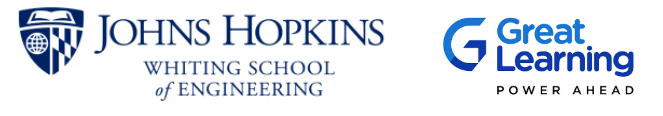

# **AI Research Synthesis Assistant**

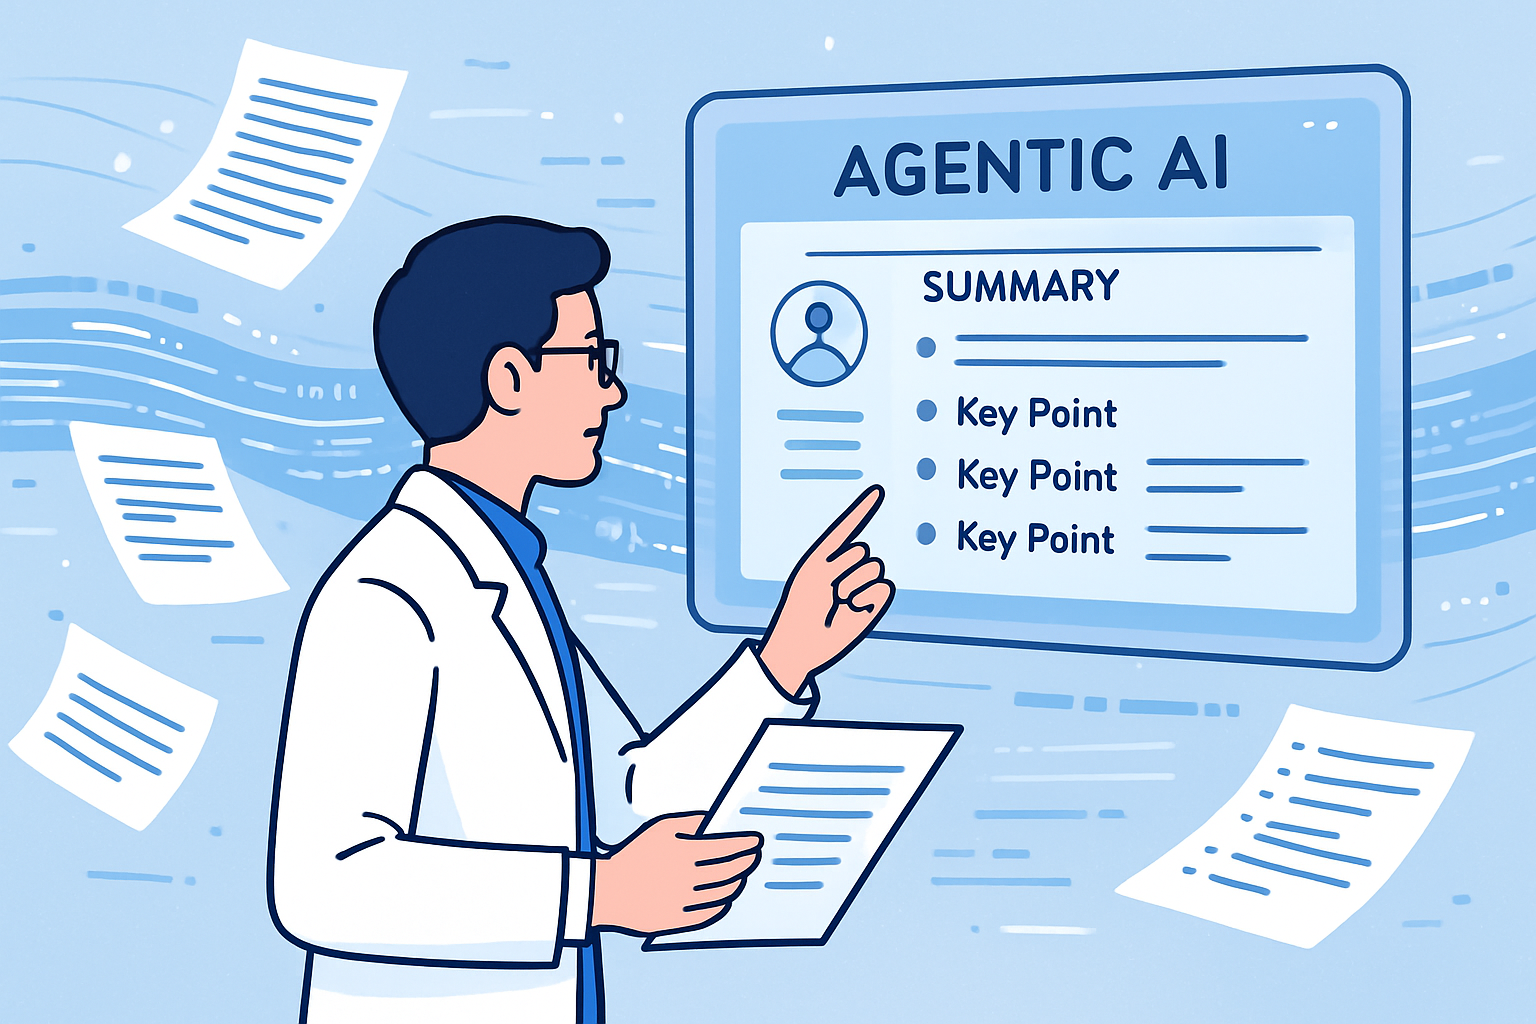

## **Problem Definition**

You are a researcher who is trying to explore the subject of Agentic AI by reading the research papers. You face the difficulty while determining which parts to prioritize and how to effectively extract meaningful information. To implement effective learning strategies, you decide to build a **Retrieval-Augmented Generation (RAG)** system.This tool helps you analyze the papers by retrieving and summarizing key content, enabling you to synthesize knowledge from complex texts. Ultimately, it supports you in evaluating and focusing on the most important ideas/information without becoming overwhelmed by technical jargons.

# **Setup**

In [ ]:
# @title Run this cell => Restart the session => Start executing the below cells **(DO NOT EXECUTE THIS CELL AGAIN)**

# -- Install other required packages with compatible versions --
!pip install langchain==0.3.25 \
                langchain-core==0.3.65 \
                langchain-openai==0.3.24 \
                chromadb==0.6.3 \
                langchain-community==0.3.20 \
                pypdf==5.4.0 \

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of langchain-text-splitters to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.4 MB/s eta

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import tiktoken

import pandas as pd

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma

# **LLM**

In [ ]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)

# **Implementing RAG**

## **1 - Loading the PDF, Chunking**

`agentic_ai_research_papers.zip` has 5 sample research papers on Agentic AI

In [ ]:
# Unzipping the Research Papers
import zipfile
with zipfile.ZipFile("/content/agentic_ai_research_papers.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")

In [ ]:
# Path of all reseach papers
research_paper_pdf_paths = [f"/content/agentic_ai_research_papers/{file}" for file in os.listdir("/content/agentic_ai_research_papers")]
research_paper_pdf_paths

['/content/agentic_ai_research_papers/AGI_via_Multi-Agent_Systems.pdf',
 '/content/agentic_ai_research_papers/AGENTIC_AI_FOR_SCIENTIFIC_DISCOVERY.pdf',
 '/content/agentic_ai_research_papers/AI_Agents_vs_Agentic_AI_A_Conceptual.pdf',
 '/content/agentic_ai_research_papers/Generative_to_Agentic_AI.pdf',
 '/content/agentic_ai_research_papers/The_role_of_agentic_AI_in_shaping_a_smart_future_A_systematic_review.pdf']

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(path = "/content/agentic_ai_research_papers/")

Here we have used the `PyPDFDirectorLoader` because we are working with multiple documents in various files within a folder. It would then load each file, break it into chunks, and store these chunks in a list. This process involves looping over each file in the directory, chunking the file, and storing the chunks.

If it was for a single file in that case, we would use the `PyPDFLoader`.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=1000,
    chunk_overlap=200
)

In [ ]:
research_papers_chunks = loader.load_and_split(text_splitter)

(Note: Expect that the above cell may take time to execute).

In [ ]:
len(research_papers_chunks)

186

## **2 - Vector Store - ChromaDB, Embeddings**

In [ ]:
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002')

In [ ]:
vectorstore = Chroma.from_documents(
    research_papers_chunks,
    embedding_model,
    collection_name="Research_Papers"
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 10}
)

## **3 - RAG Q&A**

### **Prompt Design**

In [ ]:
qna_system_message = """
You are an assistant whose work is to review the articles and provide the appropriate answers from the context.
User input will have the context required by you to answer user questions.
This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Please answer only using the context provided in the input. Do not mention anything about the context in your final answer.

If the answer is not found in the context, respond "I don't know".
"""

In [ ]:
qna_user_message_template = """
###Context
Here are some documents that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### **Retrieving the Relevant Documents**

In [ ]:
user_input = "Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions`"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [ ]:
# Here the length is 10 because, earlier we have declared k=10
len(relevant_document_chunks)

10

In [ ]:
formatted_prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_input)}
                [/INST]"""

# This is the prompt, we are feeding to the LLM
print(formatted_prompt)

[INST]
You are an assistant whose work is to review the articles and provide the appropriate answers from the context.
User input will have the context required by you to answer user questions.
This context will begin with the token: ###Context.
The context contains references to specific portions of a document relevant to the user query.

User questions will begin with the token: ###Question.

Please answer only using the context provided in the input. Do not mention anything about the context in your final answer.

If the answer is not found in the context, respond "I don't know".


                user: 
###Context
Here are some documents that are relevant to the question mentioned below.
Published as a conference paper at ICLR 2025
AGENTIC AI FOR SCIENTIFIC DISCOVERY : A S URVEY
OF PROGRESS , C HALLENGES , AND FUTURE DIREC -
TIONS
Mourad Gridach, Jay Nanavati, Khaldoun Zine El Abidine, Lenon Mendes & Christina Mack
IQVIA
{firstname.lastname}@iqvia.com
ABSTRACT
The integration of Ag

In [ ]:
resp = llm.invoke(formatted_prompt)
resp.content

'The integration of Agentic AI into scientific discovery marks a new frontier in research automation. These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming how scientists perform literature review, generate hypotheses, conduct experiments, and analyze results. This survey provides a comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems and tools, and highlighting recent progress across fields such as chemistry, biology, and materials science. We discuss key evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed understanding of the current state of the field. Finally, we address critical challenges such as literature review automation, system reliability, and ethical concerns while outlining future research directions that emphasize human-AI collaboration and enhanced system calibration.'

### **Defining the RAG function for response**




In [ ]:
def RAG(user_input):
    """
    Args:
    user_input: Takes a user input for which the response should be retrieved from the vectorDB.
    Returns:
    relevant context as per user query.
    """
    relevant_document_chunks = retriever.get_relevant_documents(user_input)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = ". ".join(context_list)



    # Combine user_prompt and system_message to create the prompt
    prompt = f"""[INST]{qna_system_message}\n
                {'user'}: {qna_user_message_template.format(context=context_for_query, question=user_input)}
                [/INST]"""

    # Quering an LLM
    try:
        response = llm.invoke(prompt)

    except Exception as e:
        response = f'Sorry, I encountered the following error: \n {e}'

    return response.content

In [ ]:
print(RAG("What are the key aspects of an Agentic AI systems?"))

The key aspects of Agentic AI systems include:

1. **Autonomy**: The ability to operate independently, making decisions and taking actions without direct human intervention.
2. **Goal-oriented behavior**: Designed to pursue specific objectives and optimize actions to achieve desired outcomes.
3. **Environmental interaction**: The capability to perceive and adapt to changes in surroundings, functioning effectively in dynamic real-world scenarios.
4. **Learning capability**: The ability to improve performance over time through machine learning or reinforcement learning by leveraging past experiences.
5. **Workflow optimization**: Enhancing business processes by integrating language understanding, reasoning, planning, and decision-making for improved resource allocation and automation opportunities.
6. **Multi-agent systems**: Facilitating communication and collaboration among multiple agents for complex workflows and integration with other tools or systems.


In [ ]:
user_input = "List down all the 5 titles of the actual research papers and not the refrence research papers."
output = RAG(user_input)
print(output)

1. "Agentic AI in Predictive AIOps: Enhancing IT Autonomy and Performance"
2. "The role of cognitive architectures in General Artificial Intelligence"
3. "Cognitive architectures for artificial intelligence ethics"
4. "Large Language Models and Cognitive Science: A Comprehensive Review of Similarities, Differences, and Challenges"
5. "Behaviour Based AI, Cognitive Processes, And Emergent Behaviors in Autonomous Agents"


In [ ]:
print(RAG("List down the authors of the research paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions` "))

Mourad Gridach, Jay Nanavati, Khaldoun Zine El Abidine, Lenon Mendes & Christina Mack


In [ ]:
print(RAG("What can be the evaluation metrics for the Agentic AI systems?"))

Evaluation metrics for Agentic AI systems can include:

1. **NeurIPS-style paper evaluation metrics**: These assess quality, significance, clarity, soundness, presentation, and contribution of AI-generated research papers.
2. **Success rates**: This tracks the percentage of successfully completed workflows.
3. **Human and automated reviewer comparisons**: Ensures consistency and reliability in evaluations.
4. **Usability and satisfaction metrics**: Such as utility, continuation, and user satisfaction to assess ease of use and overall user experience.
5. **Objective performance measures**: Including success rates and prediction accuracy combined with subjective human assessments like explainability.

For more complex tasks such as multi-agent cooperation in experimental automation or hypothesis generation, standardized evaluation metrics are still being developed to accurately gauge performance in real-world applications.


In [ ]:
print(RAG("What is the major difference between the Agents vs Agentic AI?"))

The major difference between AI Agents and Agentic AI lies in their operational complexity and collaboration capabilities. AI Agents are autonomous software programs that perform specific tasks with high autonomy within those tasks, typically handling single, defined tasks independently. In contrast, Agentic AI systems consist of multiple AI agents collaborating to achieve complex goals, managing multi-step tasks that require coordination among agents. This includes broader levels of autonomy and the ability to learn and adapt across a wider range of tasks and environments through inter-agent communication and cooperation.


In [ ]:
print(RAG("Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions`"))

The integration of Agentic AI into scientific discovery marks a new frontier in research automation. These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming how scientists perform literature review, generate hypotheses, conduct experiments, and analyze results. This survey provides a comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems and tools, and highlighting recent progress across fields such as chemistry, biology, and materials science. We discuss key evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed understanding of the current state of the field. Finally, we address critical challenges such as literature review automation, system reliability, and ethical concerns while outlining future research directions that emphasize human-AI collaboration and enhanced system calibration.


## **4 - Evaluation**

Let us now use the LLM-as-a-judge method to check the quality of the RAG system on two parameters - retrieval and generation. We illustrate this evaluation based on the answeres generated to the question from the previous section.

- We are using the same  model for evaluation, so basically here the llm is rating itself on how well he has performed in the task.

In [ ]:
user_input = "What are the key aspects of an Agentic AI systems?"

In [ ]:
relevant_document_chunks = retriever.get_relevant_documents(user_input)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [ ]:
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

In [ ]:
# Default answer for an RAG query
answer = RAG(user_input)
print(answer)

The key aspects of Agentic AI systems include:

1. **Autonomy**: The ability to operate independently, making decisions and taking actions without direct human intervention.
2. **Goal-oriented behavior**: Designed to pursue specific objectives and optimize actions to achieve desired outcomes.
3. **Environmental interaction**: Capability to perceive and adapt to changes in surroundings, functioning effectively in dynamic real-world scenarios.
4. **Learning capability**: Ability to improve performance over time through machine learning or reinforcement learning by leveraging past experiences.
5. **Workflow optimization**: Enhances business processes by integrating language understanding, reasoning, planning, and decision-making for improved resource allocation and automation opportunities.
6. **Multi-agent systems**: Facilitates communication and collaboration among multiple agents for complex workflows and integration with other tools or systems.


### 1. Groundness

In [ ]:
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context

Instructions:
1. First write down the steps that are needed to evaluate the answer as per the metric.
2. Give a step-by-step explanation if the answer adheres to the metric considering the question and context as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the answer using the evaluaton criteria and assign a score.
"""

In [ ]:
# Combining groundedness_rater_system_message + llm_prompt + answer for evaluation
groundedness_prompt = f"""[INST]{groundedness_rater_system_message}\n
            {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=answer)}
            [/INST]"""

groundness_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)
groundness_response = groundness_checker.invoke(groundedness_prompt)

print(groundness_response.content)

### Steps to Evaluate the Answer

1. **Identify Key Aspects in Context**: Review the context provided to extract key aspects of Agentic AI systems as mentioned.
2. **Compare with AI Generated Answer**: Analyze the AI-generated answer to see if it accurately reflects and derives its content solely from the context.
3. **Check for Completeness and Accuracy**: Ensure that all key aspects mentioned in the context are included in the answer, and verify their accuracy based on what is stated in the context.
4. **Assess Adherence to Metric**: Determine how well the answer adheres to deriving information only from provided context.

### Step-by-Step Explanation

1. The question asks for "key aspects of an Agentic AI system."
2. The provided context outlines several characteristics of Agentic AI, specifically detailing six key aspects:
   - Autonomy
   - Goal-oriented behavior
   - Environmental interaction
   - Learning capability
   - Workflow optimization
   - Multi-agent systems
   
3. The 

### 2. Relevance

In [ ]:
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. First write down the steps that are needed to evaluate the context as per the metric.
2. Give a step-by-step explanation if the context adheres to the metric considering the question as the input.
3. Next, evaluate the extent to which the metric is followed.
4. Use the previous information to rate the context using the evaluaton criteria and assign a score.
"""

In [ ]:
# Combining relevance_rater_system_message + llm_prompt + answer for evaluation
relevance_prompt = f"""[INST]{relevance_rater_system_message}\n
            {'user'}: {user_message_template.format(context=context_for_query, question=user_input, answer=answer)}
            [/INST]"""

relevance_checker = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=500,
    top_p=0.95,
    frequency_penalty=1.2,
    stop_sequences=['INST']
)
relevance_response = relevance_checker.invoke(relevance_prompt)

print(relevance_response.content)

### Steps to Evaluate the Context as per the Metric

1. **Identify Key Aspects of the Question**: Determine what specific information is being asked in the question about Agentic AI systems.
2. **Analyze Context for Relevant Information**: Review the provided context to find sections that directly address or relate to those key aspects identified in step 1.
3. **Check Completeness and Exclusivity**: Assess whether all important aspects of Agentic AI are covered in the answer and if any irrelevant information is included.
4. **Evaluate Clarity and Coherence**: Ensure that the answer presents a clear, coherent summary of relevant points without ambiguity.

### Step-by-Step Explanation of Adherence to Metric

1. The question asks for "key aspects" of Agentic AI systems, which implies a need for a concise list or description highlighting their main characteristics.
2. The context provides detailed descriptions under various headings, including autonomy, goal-oriented behavior, environmenta

# **Conclusion**
- In this notebook, we have learned how to create a Retrieval-Augmented Generation (RAG) based application, which can perform Q&A on research papers for quicker, more efficient, and accurate information retrieval.